In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline

# Exploratory Data Analysis
This informs our decision on the forecasting models to implement

In [3]:
data = pd.read_csv('data.csv', index_col='Date', parse_dates=True, dayfirst=True)
data.head()

,Number of Visitors
Date,
Jan-91,177400
Feb-91,190600
Mar-91,189200
Apr-91,168000
May-91,161400


In [4]:
data.tail()

,Number of Visitors
Date,
Aug-16,632600
Sep-16,647200
Oct-16,694300
Nov-16,720500
Dec-16,971800


In [5]:
idx = pd.date_range("1991-01", periods=312, freq="M")
data = data.set_index(idx)

In [6]:
y=data['Number of Y'].copy()
y.index = y.index.to_period(freq='M')

In [7]:
ts=data['Number of Y']

In [8]:
data.describe().round(2)

,Number of Visitors
count,312.00
mean,419407.37
std,132443.06
min,161400.00
25%,332625.00
50%,412950.00
75%,488775.00
max,971800.00


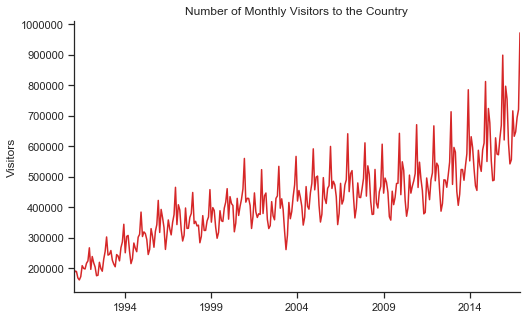

In [9]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('Visitors')
ax.set_title('Time Series Data')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

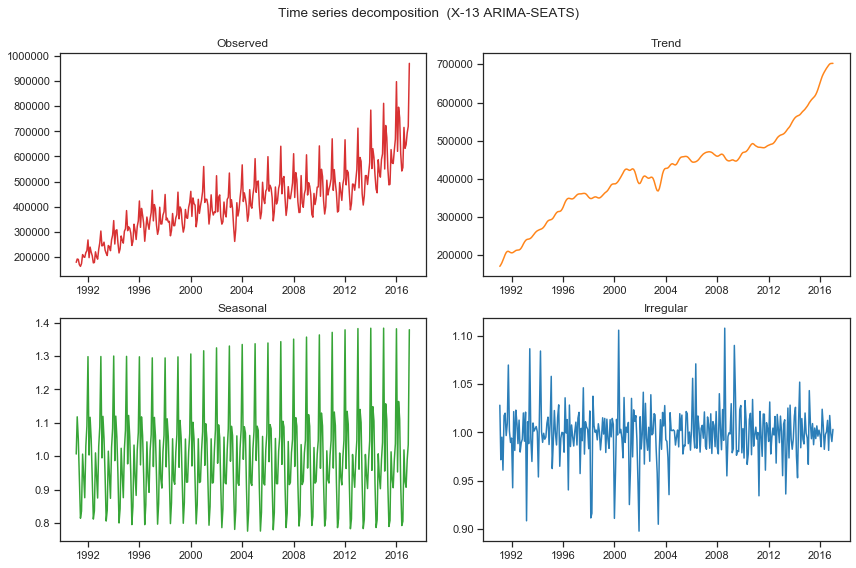

In [10]:
import os 
os.chdir(r'C:\Users\...\x13as')
decomposition = sm.tsa.x13_arima_analysis(ts)
from forecast import plot_components_x13
plot_components_x13(decomposition)
plt.show()

# Methodology
For both Seasonal Random Walk and Additive Holt Winters Model

In [11]:
diagnostics_idx=y['1992-01':].index
start_diagnostic_walk = y.index.get_loc('1992-01') 

pred_diagnostic_walk = [] # seasonal random walk
diff=[]

for i in range(start_diagnostic_walk, len(y)):
    
    pred_diagnostic_walk.append(y.iloc[i-12])
    
diagnostic_walk=pd.Series(pred_diagnostic_walk, index=diagnostics_idx)

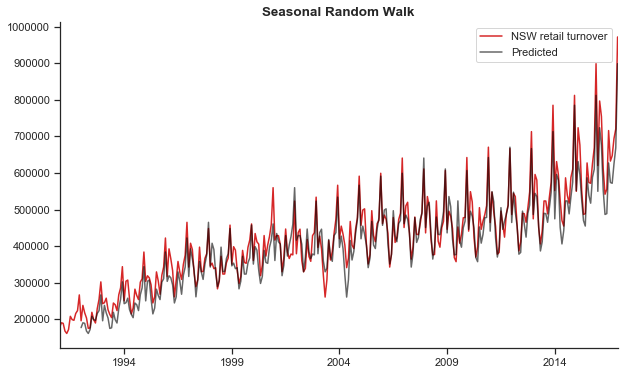

In [12]:
fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='NSW retail turnover')
diagnostic_walk.plot(color='black', label='Predicted', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Seasonal Random Walk', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

In [13]:
import forecast
ahw=forecast.holtwinters(y, additive=True, damped=False, m=12)
ahw.fit()
ahw.summary()

 Additive Holt-winters exponential smoothing

 Smoothing parameters:
 alpha (level)    0.259 (0.040)
 beta  (trend)    0.024 (0.019)
 delta (seasonal) 0.582 (0.064)
 
 In-sample fit:
 MSE               475476792.239
 RMSE              21805.430
 Log-likelihood   -3559.562
 AIC               7127.124
 BIC               7142.096


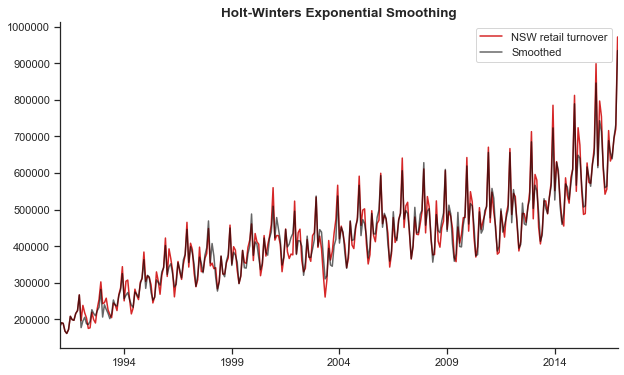

In [14]:
smoothed_ahw=pd.Series(ahw.smooth(), index=y.index)

fig, ax= plt.subplots(figsize=(10,6))

y.plot(color='#D62728', label='NSW retail turnover')
smoothed_ahw.plot(color='black', label='Smoothed', alpha=0.6)
plt.legend(loc='best')
ax.set_xlabel('')
ax.set_xticks([], minor=True)
ax.set_title(r'Holt-Winters Exponential Smoothing', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

# Model Diagnostics

For Seasonal Random Walk Model

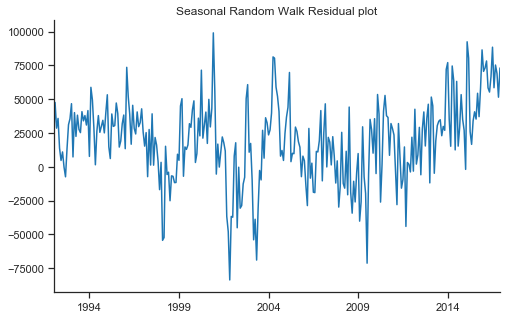

In [15]:
resid_walk = (y['1992-01':]-diagnostic_walk) # we dont use the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid_walk.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Seasonal Random Walk Residual plot')
sns.despine()
plt.show()

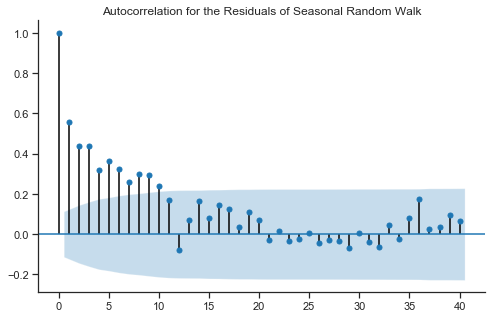

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid_walk, lags=40, ax=ax)
sns.despine()
plt.title('Autocorrelation for the Residuals of Seasonal Random Walk')
plt.show()

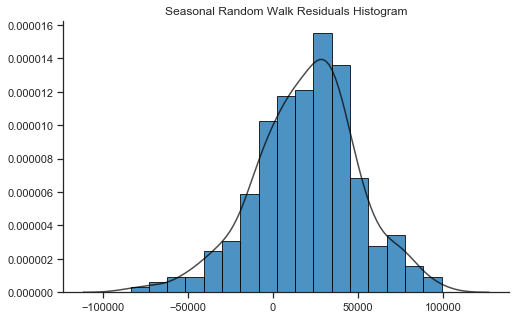

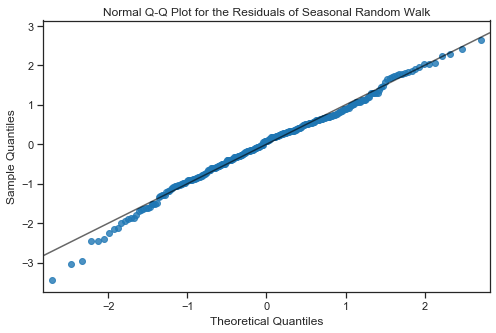

In [17]:
from forecast import histogram, qq_plot

histogram(resid_walk)
plt.title('Seasonal Random Walk Residuals Histogram')
plt.show()

qq_plot(resid_walk)
plt.title('Normal Q-Q Plot for the Residuals of Seasonal Random Walk')
plt.show()

For the Additive Holt Winters Model

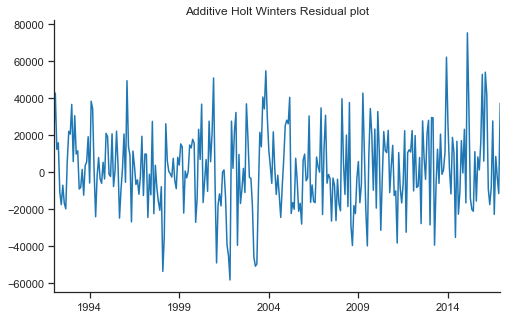

In [18]:
resid_ahw = (y-ahw.smooth())[12:] # we remove the first 12 observations as they are for initialisitation only

fig, ax= plt.subplots(figsize=(8,5))
resid_ahw.plot(color=blue)
ax.set_xlabel('')
ax.set_xticks([], minor=True) 
ax.set_title('Additive Holt Winters Residual plot')
sns.despine()
plt.show()

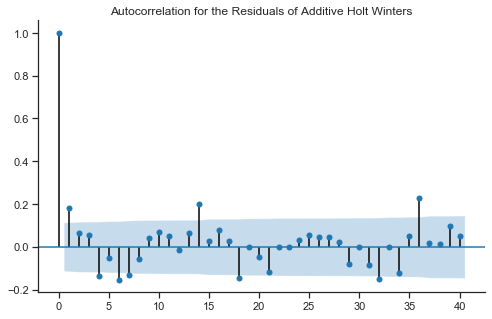

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
sm.graphics.tsa.plot_acf(resid_ahw, lags=40, ax=ax)
sns.despine()
plt.title('Autocorrelation for the Residuals of Additive Holt Winters')
plt.show()

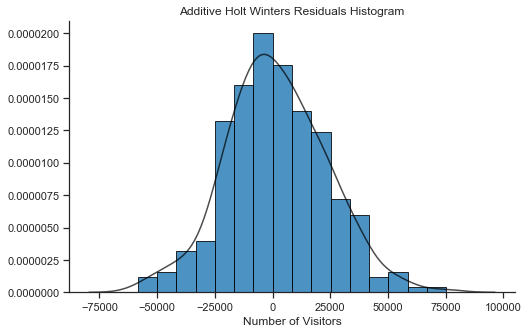

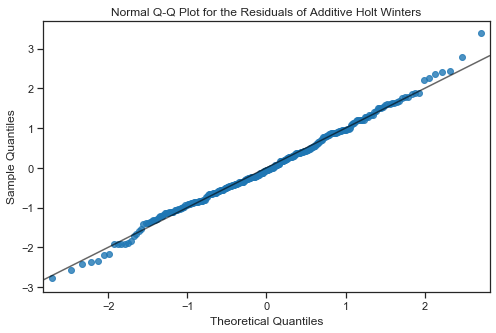

In [20]:
from forecast import histogram, qq_plot

histogram(resid_ahw)
plt.title('Additive Holt Winters Residuals Histogram')
plt.show()

qq_plot(resid_ahw)
plt.title('Normal Q-Q Plot for the Residuals of Additive Holt Winters')
plt.show()

# Model Validations

In [21]:
validation=y['2004-01':].index
start = y.index.get_loc('2004-01') 

pred1 = [] # seasonal random walk
pred2 = [] # additive holt winters
actual= []

for i in range(start, len(y)):
    
    actual.append(y.iloc[i]) # actual value
    
    pred1.append(y.iloc[i-12]) # seasonal random walk forecast
    
    model = forecast.holtwinters(y.iloc[:i], additive=True, damped=False, m=12)
    model.fit()
    pred2.append(model.forecast(1)[0]) # additive holt winters forecast

columns=['Seasonal RW', 'Additive', 'Actual']
results = np.vstack([pred1,pred2,actual]).T
results = pd.DataFrame(results, columns=columns, index=validation)

In [22]:
from statlearning import rmse_jack

table = pd.DataFrame(0.0, index=results.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0], table.iloc[i,1] = rmse_jack(results.iloc[:,i], results.iloc[:,-1])
table.round(2)

,RMSE,SE
Seasonal RW,38212.84,1995.79
Additive,27171.11,1910.03


# Forecasting Results

Seasonal Random Walk Model

In [23]:
h=24

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

In [24]:
forecast_walk=[]

u=0
p=0

for i in range(h):
    
    forecast_walk.append(y.iloc[i-12-p]) # seasonal random walk forecast
    
    u=u+1
    if u>11:
        u=0
        p=p+12
        
forecast_walk_series=pd.Series(forecast_walk, index=test)
print(forecast_walk_series)

2017-01    620500
2017-02    796800
2017-03    754600
2017-04    610800
2017-05    542000
2017-06    555800
2017-07    716000
2017-08    632600
2017-09    647200
2017-10    694300
2017-11    720500
2017-12    971800
2018-01    620500
2018-02    796800
2018-03    754600
2018-04    610800
2018-05    542000
2018-06    555800
2018-07    716000
2018-08    632600
2018-09    647200
2018-10    694300
2018-11    720500
2018-12    971800
Freq: M, dtype: int64


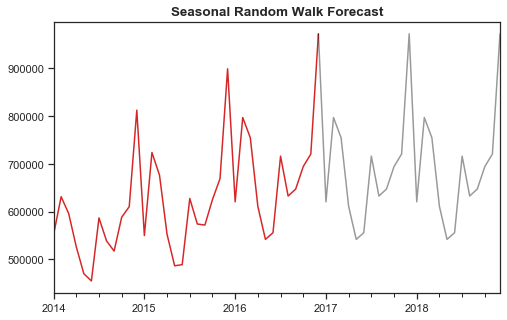

In [25]:
last=y['2014-01':].iloc[-1:]
extended=last.append(forecast_walk_series)

with sns.axes_style('ticks'):
    fig, ax= plt.subplots(figsize=(8,5))
    y['2014-01':].plot(color='#D62728')
    extended.plot(color='black', alpha=0.4, label='Point forecast')
    hold = ax.get_ylim()
    ax.set_title(r'Seasonal Random Walk Forecast', fontsize=13.5, fontweight='bold')
    ax.set_ylim(hold)

In [26]:
forecast_ahw_series=pd.Series(ahw.forecast(h), index=test)

print(round(forecast_ahw_series,-2))

2017-01     664300.0
2017-02     791400.0
2017-03     747500.0
2017-04     643400.0
2017-05     585400.0
2017-06     594200.0
2017-07     720800.0
2017-08     680500.0
2017-09     669700.0
2017-10     725700.0
2017-11     761400.0
2017-12     966900.0
2018-01     699600.0
2018-02     826700.0
2018-03     782800.0
2018-04     678700.0
2018-05     620700.0
2018-06     629500.0
2018-07     756000.0
2018-08     715800.0
2018-09     705000.0
2018-10     761000.0
2018-11     796700.0
2018-12    1002200.0
Freq: M, dtype: float64


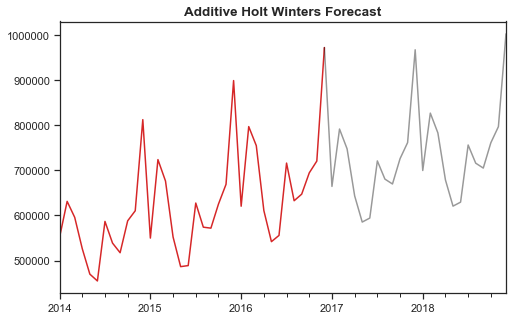

In [27]:
last=y['2014-01':].iloc[-1:]
extended=last.append(forecast_ahw_series)

with sns.axes_style('ticks'):
    fig, ax= plt.subplots(figsize=(8,5))
    y['2014-01':].plot(color='#D62728')
    extended.plot(color='black', alpha=0.4, label='Point forecast')
    hold = ax.get_ylim()
    ax.set_title(r'Additive Holt Winters Forecast', fontsize=13.5, fontweight='bold')
    ax.set_ylim(hold)

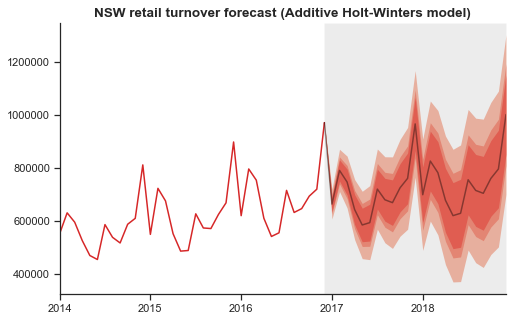

In [28]:
h=24

test=pd.period_range(start=y.index[-1]+1, periods=h, freq='M')

pred=pd.Series(ahw.forecast(h), index=test)

var = ahw.forecastvariance(h)


intv1=pd.DataFrame(ahw.intervalforecast(h, level=.8), index=test)
intv2=pd.DataFrame(ahw.intervalforecast(h, level=.9), index=test)
intv3=pd.DataFrame(ahw.intervalforecast(h, level=.99), index=test)

fig, ax = forecast.fanchart(y['01-2014':], forecast_ahw_series, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Additive Holt-Winters model', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()

In [29]:
diff1=(intv1[0]-intv1[1])/2
diff2=(intv2[0]-intv2[1])/2
diff3=(intv3[0]-intv3[1])/2

In [30]:
intv1_new=intv1
intv1_new[0]=forecast_walk_series+diff1
intv1_new[1]=forecast_walk_series-diff1
intv2_new=intv2
intv2_new[0]=forecast_walk_series+diff2
intv2_new[1]=forecast_walk_series-diff2
intv3_new=intv3
intv3_new[0]=forecast_walk_series+diff3
intv3_new[1]=forecast_walk_series-diff3

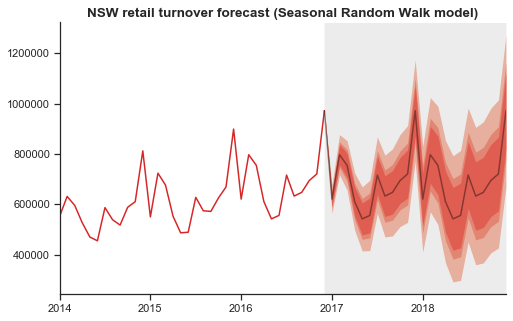

In [31]:
fig, ax = forecast.fanchart(y['01-2014':], forecast_walk_series, intv1_new, intv2_new, intv3_new)
ax.set_xlabel('')
ax.set_xticks([], minor=True)

plt.title('Seasonal Random Walk model', fontsize=13.5, fontweight='bold')
sns.despine()
plt.show()